<a href="https://colab.research.google.com/github/dniggl/Insights/blob/main/Sentiment_Analysis_on_Solar_Panels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Sentiment analysis on tweets related to solar energy.   

**Import the Required Libraries**

In [ ]:
# Install Tweepy
!pip install tweepy

In [ ]:
# Import the required libraries.
import os
import tweepy as tw
import numpy as np
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon')
import re
import pandas as pd
from wordcloud import WordCloud
import seaborn as sns
import matplotlib.pyplot as plt


Tweepy is an open source Python package that gives you an easy way to access the Twitter API with Python. 

**Get Twitter Data**

For this project, we are going to extract data from Twitter using the Tritter API. You are required to set up a Twitter developer account prior to using their API. I will not cover this process here, but you can find out how by going to this link https://python.plainenglish.io/scraping-twitter-data-with-an-api-and-python-445a4de4b18  

Assign your Twitter Developer APIs and access tokens to variables.

In [ ]:
# Connecting to your Twitter Developer API's.
api_key= 'API Key Here' 
api_secret= 'API Secret Key Here'
access_token= 'Access Token Here'
access_token_secret= 'Access Token Secret Here'

Authenticate the APIs and Access Tokens.

In [ ]:
# Authenticate the APIs
auth = tw.OAuthHandler(api_key, api_secret)
auth.set_access_token(access_token, access_token_secret)
api = tw.API(auth, wait_on_rate_limit=True)

Define the search words and start date as variables.

In [ ]:
# Define the search words and the start date as variables.
search_words = "solar energy"
date_since = "2021-01-01"

Collect the tweets using the search words and start date.

In [ ]:
# Collect the tweets.
tweets = tw.Cursor(api.search,
              q = search_words,
              lang = "en",
              since = date_since).items(3000)

Define a function to get Twitter users, tweet times, and tweet text for tweets that match the search criteria and create a new data frame.

In [ ]:
# Define a function to get the related tweets.
def get_related_tweets(key_word):
    twitter_users = []
    tweet_time = []
    tweet_string = [] 
    for tweet in tw.Cursor(api.search,q=key_word, count=3000).items(3000):
             if (not tweet.retweeted) and ('RT @' not in tweet.text):
                if tweet.lang == "en":
                    twitter_users.append(tweet.user.name)
                    tweet_time.append(tweet.created_at)
                    tweet_string.append(tweet.text)
                    
    df = pd.DataFrame({'name':twitter_users, 'time': tweet_time, 'tweet': tweet_string})
    df.to_csv(f"{key_word}.csv")
    return df

Call the function to get tweets that contain text for solar energy and display a few tweets.

In [ ]:
# Get tweets related to solar energy and create a new dataframe.
df = get_related_tweets("solar energy")
df.head(5)

,name,time,tweet
0,Leslie Myers,2022-06-09 21:06:05,Look at that beautiful array! Funded by Puget ...
1,Pew Research Science,2022-06-09 21:06:03,When asked about specific sources of energy in...
2,Fifi Lamour,2022-06-09 21:05:04,I see the international push for nuclear is on...
3,Thomas Anderson,2022-06-09 21:04:51,The U.S. Solar Boom Is Back On Track #solarene...
4,None,2022-06-09 21:03:21,Electric powered vehicles power is equal to it...


**Data Cleaning**

The text within tweets contain many slang words and punctuation marks. We need to preprocess and clean the text in the tweets before they can be used for sentiment analysis. Text preprocessing is one of the most important tasks in Natural Language Processing (NLP). For example, you may want to remove all punctuation marks within the text before they can be used for text classification.

We will use Regular Expressions (Regex) to perform the text preprocessing tasks. A Regular Expression is a text string that describes a search pattern which can be used to match or replace patterns inside a string with a minimal amount of code. Python’s re package will be used to implement regular expressions. To learn more about regular expressions, click this link https://stackabuse.com/using-regex-for-text-manipulation-in-python/

In [ ]:
# Create variable containing tweets.  
tweets = df.iloc[:, 2].values

In [ ]:
# Clean the text data by preprocessing it with Regex. 
processed_tweets = []

for sentence in range(0, len(tweets)):
    # Remove all the special characters.
    processed_tweet = re.sub(r'\W', ' ', str(tweets[sentence]))

    # Remove all single characters as a result of removing the special characters.
    processed_tweet= re.sub(r'\s+[a-zA-Z]\s+', ' ', processed_tweet)

    # Remove single characters from the start.
    processed_tweet = re.sub(r'\^[a-zA-Z]\s+', ' ', processed_tweet) 

    # Replace multiple spaces with a single space.
    processed_tweet = re.sub(r'\s+', ' ', processed_tweet, flags=re.I)

    # Remove links from text.
    processed_tweet = re.sub(r'http\S+', '', processed_tweet)

    # Remove prefixed 'b'.
    processed_tweet = re.sub(r'^b\s+', '', processed_tweet)

    processed_tweets.append(processed_tweet)

In [ ]:
# Create a new data frame for the processed tweets. 
clean_tweets = pd.DataFrame({'tweet': processed_tweets})
clean_tweets.head(5)

,tweet
0,Look at that beautiful array Funded by Puget S...
1,When asked about specific sources of energy in...
2,I see the international push for nuclear is on...
3,The S Solar Boom Is Back On Track solarenergy ...
4,Electric powered vehicles power is equal to it...


**Apply Sentiment Analysis**

Sentiment analysis is a text analysis method that detects polarity (positive or negative opinion) within text. We will use the NLTK (Natural Language Toolkit)  submodule VADER for doing sentiment analysis on the text. 

VADER ( Valence Aware Dictionary for Sentiment Reasoning) is a module used for text sentiment analysis that is sensitive to both polarity (positive/negative) and intensity (strength) of emotion. It is applied directly to unlabeled text data and is specifically designed for sentiments expressed in social media.

VADER’s SentimentIntensityAnalyzer() takes in a string and returns a dictionary of scores in each of the following categories:
* negative
* neutral
* positive
* compound (the sum of positive, negative & neutral scores which is then normalized between -1(strongly negative) and +1 (strongly positive).

For example, the following text would return these output  scores:                       
'This was the best, most awesome movie EVER MADE!!!'                       
OUTPUT-{'neg': 0.0, 'neu': 0.425, 'pos': 0.575, 'compound': 0.8877}

The scores range between -1 to 1, with -1 being strongly negative and +1 being strongly positive. We will use the compound score to determine if tweets related to solar energy are positive or negative. 

We will now initialize the Sentiment Intensity Analyzer and create a lambda function that takes in a text string, applies the vader.polarity_scores() function on it to get the results and then return back the compound scores. Using the apply function in Pandas, we can create a new compound column in the data frame with all the compound scores for each tweet.

In [ ]:
# Initialize the SentimentIntensityAnalyzer.
vader = SentimentIntensityAnalyzer()

# Apply lambda function to get compound scores.
function = lambda title: vader.polarity_scores(title)['compound']
clean_tweets['compound'] = clean_tweets['tweet'].apply(function)

In [ ]:
clean_tweets  

,tweet,compound
0,Liberals are calling for full scale industrial...,0.0000
1,Lidl shore road are covering the roof with sol...,-0.0258
2,DukeEnergy ingrodolfohdez CastilloMarelen The...,-0.1779
3,sethmoulton Good for for wanting Nuclear Powe...,0.0772
4,Looking for quick ways to get your energy bill...,0.8225
...,...,...
442,With trade certainty in place it time for Cong...,0.8658
443,Thirty thousand NSW homes will receive free so...,0.6597
444,It NOT Solar panels mostly come from China It ...,0.0000
445,All renewable technologies including now very...,0.0000


**Visualize Sentiments**

Let’s see how the sentiments are distributed. We can better understand the common words by plotting word clouds. A word cloud (also known as text clouds) is a visualization where the more a specific word appears in the text, the bigger and bolder it will appear in the word cloud.

Let’s visualize all the words in the data using the word cloud plot.  

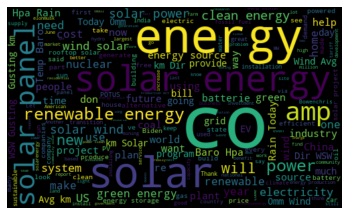

In [ ]:
# Word cloud visualization.
allWords = ' '.join([twts for twts in clean_tweets['tweet']])
wordCloud = WordCloud(width=500, height=300, random_state=21, max_font_size=110).generate(allWords)

plt.imshow(wordCloud, interpolation="bilinear")
plt.axis('off')
plt.show()

Energy and solar are common words that stand out.

Create a function to compute the negative (-1), neutral (0), and positive (+1) sentiments, and add a new column called sentiment to our data frame.

In [ ]:
# Create a function to compute negative (-1), neutral (0) and positive (+1) sentiments.
def getAnalysis(score):
 if score < 0:
    return 'Negative'
 elif score == 0:
    return 'Neutral'
 else:
    return 'Positive'

clean_tweets['sentiment'] = clean_tweets['compound'].apply(getAnalysis)

# Show the dataframe
clean_tweets

,tweet,compound,sentiment
0,Look at that beautiful array Funded by Puget S...,0.7184,Positive
1,When asked about specific sources of energy in...,0.2960,Positive
2,I see the international push for nuclear is on...,-0.2732,Negative
3,The S Solar Boom Is Back On Track solarenergy ...,0.0000,Neutral
4,Electric powered vehicles power is equal to it...,0.3400,Positive
...,...,...,...
1293,We live in world that values looking good more...,0.8176,Positive
1294,spenderallegra If renewable energy is the che...,0.4939,Positive
1295,Reon Energy Artistic Milliners announce 8 5 MW...,0.2732,Positive
1296,Jana_Shah ma am go for solar energy,0.2732,Positive


Show the counts for each sentiment. There are a total of 1,298 tweets. We see that 914 tweets are positive, 211 are negative and 173 are neutral.  

In [ ]:
# Show the counts for each sentiment.
clean_tweets['sentiment'].value_counts()

Positive    914
Neutral     211
Negative    173
Name: sentiment, dtype: int64

Visualize the counts for each sentiment.

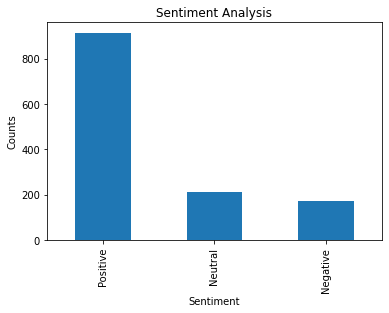

In [ ]:
# Plotting the counts.
plt.title('Sentiment Analysis')
plt.xlabel('Sentiment')
plt.ylabel('Counts')
clean_tweets['sentiment'].value_counts().plot(kind = 'bar')
plt.show()

Visualize sentiments distribution based on compound scores.

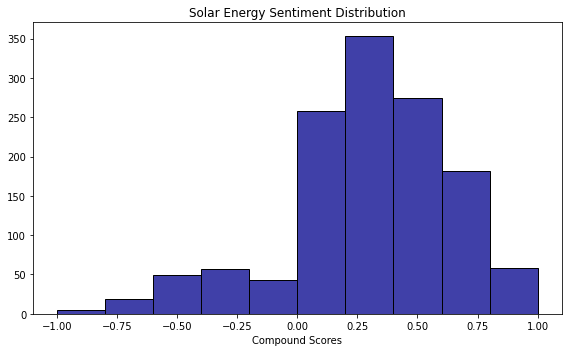

In [ ]:
plt.figure(figsize=(8, 5))
sns.histplot(clean_tweets, x='compound', color="darkblue", bins=10, binrange=(-1, 1))
plt.title("Solar Energy Sentiment Distribution")
plt.xlabel("Compound Scores")
plt.ylabel("")
plt.tight_layout()

**Conclusions**


The vast majority of tweets show positive sentiments toward solar energy. 70% of sentiments are positive, 16% are neutral, and 13% are negative. These sentiments are alligned with the survey results fron Pew Research Center. This is an encouraging sign for the future of our environment. Hopefully, more people will take action on their sentiments and start using solar energy to power their homes and drive electric or hybrid automobils.                           